In [ ]:
%cd /content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit

In [ ]:
!pip install mxnet

     |████████████████████████████████| 46.9MB 65kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import os, sys, random
import xml.etree.ElementTree as ET
import mxnet as mx
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile,copy
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
validation_annotation_loc = '/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv'
validation_annotation_file = pd.read_csv(validation_annotation_loc)
print("records present for training : ",validation_annotation_file.shape)
validation_annotation_file.head()

records present for training :  (204621, 13)


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,freeform,/m/0cmf2,1,0.022464,0.964178,0.070656,0.800164,0,0,0,0,0
1,000595fe6fee6369,freeform,/m/02wbm,1,0.000000,1.000000,0.000233,1.000000,0,0,1,0,0
2,000595fe6fee6369,freeform,/m/02xwb,1,0.141030,0.180277,0.676262,0.732455,0,0,0,0,0
3,000595fe6fee6369,freeform,/m/02xwb,1,0.213781,0.253028,0.298764,0.354956,1,0,0,0,0
4,000595fe6fee6369,freeform,/m/02xwb,1,0.232926,0.288447,0.488954,0.545146,1,0,0,0,0


In [ ]:
class_descriptions_file='/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/csv_folder/class-descriptions-boxable.csv'
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
print(class_descriptions.shape)
class_descriptions.head()

(601, 2)


,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [ ]:
car_pd = class_descriptions[class_descriptions[1]=='Car']
bus_pd = class_descriptions[class_descriptions[1]=='Bus']
train_pd = class_descriptions[class_descriptions[1]=='Train']
train_pd

,0,1
392,/m/07jdr,Train


In [ ]:
label_name_car = car_pd[0].values[0]
label_name_bus = bus_pd[0].values[0]
label_name_train = train_pd[0].values[0]
label_name_train

'/m/07jdr'

In [ ]:
car_bbox = validation_annotation_file[validation_annotation_file['LabelName']==label_name_car]
bus_bbox = validation_annotation_file[validation_annotation_file['LabelName']==label_name_bus]
train_bbox = validation_annotation_file[validation_annotation_file['LabelName']==label_name_train]
train_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
2485,02dc31437b2ec48f,freeform,/m/07jdr,1,0.000994,0.859930,0.264811,0.839058,0,1,0,0,0
4910,063842dba3fcd6e1,freeform,/m/07jdr,1,0.321809,0.990124,0.069628,0.678279,0,0,0,0,0
10914,0d318eeb57e0d683,freeform,/m/07jdr,1,0.000002,0.678127,0.322956,0.826171,0,1,0,0,0
21041,19b9ecd641b46fb1,freeform,/m/07jdr,1,0.107305,0.909610,0.222464,0.695866,0,0,0,0,0
21546,1a6cdb14397d40af,freeform,/m/07jdr,1,0.000000,1.000000,0.000021,0.972517,0,1,0,0,0


In [ ]:
print('There are %d car in the dataset' %(len(car_bbox)))
print('There are %d bus in the dataset' %(len(bus_bbox)))
print('There are %d train in the dataset' %(len(train_bbox)))

There are 9381 car in the dataset
There are 92 bus in the dataset
There are 91 train in the dataset


In [ ]:
car_img_id = car_bbox['ImageID']
bus_img_id = bus_bbox['ImageID']
train_img_id = train_bbox['ImageID']
train_img_id.count()
train_img_id

2485      02dc31437b2ec48f
4910      063842dba3fcd6e1
10914     0d318eeb57e0d683
21041     19b9ecd641b46fb1
21546     1a6cdb14397d40af
                ...       
198176    f811d03b84214789
199056    f9593d0a16b1d193
199479    f9e61241218288ba
200822    fb606f3170d6e48e
203661    feb3f8fd27b91d6e
Name: ImageID, Length: 91, dtype: object

In [ ]:
concated_df=pd.concat([car_bbox, bus_bbox, train_bbox], axis=0)
concated_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
89,001083f05db4352b,freeform,/m/0k4j,1,0.164277,0.767547,0.338296,0.821679,0,0,0,0,0
186,001a794d1865ee47,freeform,/m/0k4j,1,0.293362,0.933661,0.023560,0.889955,0,0,0,0,0
194,001a809ad40a2f84,freeform,/m/0k4j,1,0.085249,0.878526,0.166653,0.878226,0,0,0,0,0
217,0022e32008e479cb,freeform,/m/0k4j,1,0.000001,0.999991,0.000000,1.000000,0,1,0,0,0
224,00230c216711fceb,freeform,/m/0k4j,1,0.069197,0.947773,0.418904,0.946510,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198176,f811d03b84214789,freeform,/m/07jdr,1,0.045606,0.967073,0.199718,0.844927,0,0,0,0,0
199056,f9593d0a16b1d193,freeform,/m/07jdr,1,0.156365,0.814109,0.249939,0.709406,0,0,0,0,0
199479,f9e61241218288ba,freeform,/m/07jdr,1,0.000000,0.948637,0.227655,0.843477,0,1,0,0,0
200822,fb606f3170d6e48e,freeform,/m/07jdr,1,0.000169,0.998936,0.001213,0.492840,1,1,0,0,0


In [ ]:
concated_df['ClassName']=concated_df['LabelName']
concated_df['ClassName']

89         /m/0k4j
186        /m/0k4j
194        /m/0k4j
217        /m/0k4j
224        /m/0k4j
            ...   
198176    /m/07jdr
199056    /m/07jdr
199479    /m/07jdr
200822    /m/07jdr
203661    /m/07jdr
Name: ClassName, Length: 9564, dtype: object

In [ ]:
mapping = {
    label_name_car: 'Car',
    label_name_bus: 'Bus',
    label_name_train: 'Train',
}

concated_df['ClassName'] = [mapping[word] for word in concated_df['ClassName']]
concated_df['ClassName']

concated_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName
89,001083f05db4352b,freeform,/m/0k4j,1,0.164277,0.767547,0.338296,0.821679,0,0,0,0,0,Car
186,001a794d1865ee47,freeform,/m/0k4j,1,0.293362,0.933661,0.023560,0.889955,0,0,0,0,0,Car
194,001a809ad40a2f84,freeform,/m/0k4j,1,0.085249,0.878526,0.166653,0.878226,0,0,0,0,0,Car
217,0022e32008e479cb,freeform,/m/0k4j,1,0.000001,0.999991,0.000000,1.000000,0,1,0,0,0,Car
224,00230c216711fceb,freeform,/m/0k4j,1,0.069197,0.947773,0.418904,0.946510,0,0,0,0,0,Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198176,f811d03b84214789,freeform,/m/07jdr,1,0.045606,0.967073,0.199718,0.844927,0,0,0,0,0,Train
199056,f9593d0a16b1d193,freeform,/m/07jdr,1,0.156365,0.814109,0.249939,0.709406,0,0,0,0,0,Train
199479,f9e61241218288ba,freeform,/m/07jdr,1,0.000000,0.948637,0.227655,0.843477,0,1,0,0,0,Train
200822,fb606f3170d6e48e,freeform,/m/07jdr,1,0.000169,0.998936,0.001213,0.492840,1,1,0,0,0,Train


In [ ]:
validation_df= concated_df.loc[:,['ImageID','XMin','XMax','YMin','YMax','ClassName']]
validation_df

,ImageID,XMin,XMax,YMin,YMax,ClassName
89,001083f05db4352b,0.164277,0.767547,0.338296,0.821679,Car
186,001a794d1865ee47,0.293362,0.933661,0.023560,0.889955,Car
194,001a809ad40a2f84,0.085249,0.878526,0.166653,0.878226,Car
217,0022e32008e479cb,0.000001,0.999991,0.000000,1.000000,Car
224,00230c216711fceb,0.069197,0.947773,0.418904,0.946510,Car
...,...,...,...,...,...,...
198176,f811d03b84214789,0.045606,0.967073,0.199718,0.844927,Train
199056,f9593d0a16b1d193,0.156365,0.814109,0.249939,0.709406,Train
199479,f9e61241218288ba,0.000000,0.948637,0.227655,0.843477,Train
200822,fb606f3170d6e48e,0.000169,0.998936,0.001213,0.492840,Train


In [ ]:
validation_df['ImageID']=validation_df['ImageID']+'.jpg'
validation_df

,ImageID,XMin,XMax,YMin,YMax,ClassName
89,001083f05db4352b.jpg,0.164277,0.767547,0.338296,0.821679,Car
186,001a794d1865ee47.jpg,0.293362,0.933661,0.023560,0.889955,Car
194,001a809ad40a2f84.jpg,0.085249,0.878526,0.166653,0.878226,Car
217,0022e32008e479cb.jpg,0.000001,0.999991,0.000000,1.000000,Car
224,00230c216711fceb.jpg,0.069197,0.947773,0.418904,0.946510,Car
...,...,...,...,...,...,...
198176,f811d03b84214789.jpg,0.045606,0.967073,0.199718,0.844927,Train
199056,f9593d0a16b1d193.jpg,0.156365,0.814109,0.249939,0.709406,Train
199479,f9e61241218288ba.jpg,0.000000,0.948637,0.227655,0.843477,Train
200822,fb606f3170d6e48e.jpg,0.000169,0.998936,0.001213,0.492840,Train


In [ ]:
validation_df.shape
validation_df.to_csv('validation.csv')

In [ ]:
validation_df['ClassName'].value_counts()

Car      9381
Bus        92
Train      91
Name: ClassName, dtype: int64

In [ ]:
%cd /content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation
!mkdir validation
print('Validation folder created!!')

/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation
Validation folder created!!


In [ ]:
import shutil
folders = ['Car','Bus','Train']
folder = '/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/validation'
for i in folders:
  path = '/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/' + i  
  for j in os.listdir(path):
    img = path + '/' + j
    try:
      shutil.copy(img,folder)
      print(img + ' copied!!')
    except IsADirectoryError:
      print(img + 'Is a directory!!')
      continue
    except shutil.SameFileError:      
      continue

/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/00acf53b127218c2.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/017f34d289d6e1dc.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/06326de7b4fd3637.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/07d5ccdc241cdb1a.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/11bb0d1c7c76af7c.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/20fb1a492c1fd781.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/27c29ad8400b5b97.jpg copied!!
/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/Car/2d524ceb6aa14d24.jpg copied!!
/content/drive/MyDrive/ColabProjects/Fas

In [ ]:
import os
files = []
path = '/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/validation'

for i in os.listdir(path):
  files.append(i)
print("Images found: ",len(files))

Images found:  150


In [ ]:
%cd /content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit
train_df = pd.read_csv('/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/validation.csv')
p = '/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/OID/Dataset/validation/validation/'

found=0
notFound=0
with open("annotation_validation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
    n = row['ImageID']
    if n in files:
      found+=1
      img = cv2.imread(p + n)
      #print(img)  #none 
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      train_file_path = p
      fileName = os.path.join(train_file_path, row['ImageID'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
    else:
      notFound+=1
print('Found: ',found)
print('Not Found: ',notFound)

/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit
Found:  244
Not Found:  9320


In [1]:
f = open('/content/drive/MyDrive/ColabProjects/Faster-RCNN/OIDv4_ToolKit/annotation_validation.txt','r')
lines = f.readlines()

(768, 1024)
Car



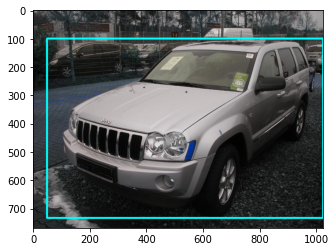

In [2]:
import cv2
import matplotlib.pyplot as plt

line = lines[0]
temp = line.split(',')

img = cv2.imread(temp[0])
x1 = int (temp[1])
y1 = int (temp[2])
x2 = int (temp[3])
y2 = int (temp[4])
c = temp[5]
img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,255),5)
print(img.shape[:2])
print(c)
plt.imshow(img)
plt.show()